In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2lab
import time

def cal_ssd(patch, region, alpha, center_patch):
    """
    计算 patch 和 region 的 SSD 并进行指数转换。
    """
    patch_size = patch.shape
    region_size = region.shape
    SSD_region = np.zeros((region_size[0], region_size[1]))

    for row in range(center_patch[0], region_size[0] - center_patch[0]):
        for col in range(center_patch[1], region_size[1] - center_patch[1]):
            temp = region[row - center_patch[0]: row + center_patch[0] + 1, col - center_patch[1]: col + center_patch[1] + 1, :] - patch
            SSD_region[row, col] = np.sum(temp ** 2)
            SSD_region[row, col] = np.exp(-alpha * SSD_region[row, col])

    return SSD_region

def cart2polar(region_size):
    """
    将直角坐标转换为以区域中心为原点的极坐标。
    """
    radius = np.zeros(region_size)
    angle = np.zeros(region_size)
    center = (region_size[0] // 2, region_size[1] // 2)

    for row in range(region_size[0]):
        for col in range(region_size[1]):
            rho, theta = np.hypot(row - center[0], col - center[1]), np.arctan2(row - center[0], col - center[1])
            radius[row, col] = np.log(rho) if rho != 0 else 0
            angle[row, col] = np.degrees(theta) + 180

    return radius, angle

def get_bin(radius, angle, region_size):
    """
    将极坐标系划分为 15 * 3 = 45 个 bin。
    """
    max_radius = np.max(radius)
    bin = [[[] for _ in range(3)] for _ in range(15)]

    for m in range(15):
        theta_low, theta_up = m * 24, (m + 1) * 24
        for n in range(3):
            rho_low, rho_up = max_radius * n / 3, max_radius * (n + 1) / 3
            for row in range(region_size[0]):
                for col in range(region_size[1]):
                    if rho_low <= radius[row, col] <= rho_up and theta_low <= angle[row, col] <= theta_up:
                        bin[m][n].append((row, col))

    return bin

def get_self_sim_vec(ssd_region, bin, vec_size):
    """
    将相似性转换为自相似性描述子向量。
    """
    self_similarities_vec = np.zeros(vec_size)
    num = 0

    for m in range(15):
        for n in range(3):
            max_value = 0
            for row, col in bin[m][n]:
                max_value = max(max_value, ssd_region[row, col])
            self_similarities_vec[num] = max_value
            num += 1

    return self_similarities_vec

def com_self_similarities(src_image, region_size, patch_size, bin):
    """
    计算图片的自相似性描述子。
    """
    start_time = time.time()
    lab_image = rgb2lab(src_image)
    lab_size = lab_image.shape
    vec_size = 45
    alpha = 1 / (85 ** 2)
    self_similarities = np.zeros((lab_size[0], lab_size[1], vec_size))
    center_region = [region_size[0] // 2, region_size[1] // 2]
    center_patch = [patch_size[0] // 2, patch_size[1] // 2]

    for row in range(center_region[0], lab_size[0] - center_region[0]):
        for col in range(center_region[1], lab_size[1] - center_region[1]):
            patch = lab_image[row - center_patch[0]: row + center_patch[0] + 1, col - center_patch[1]: col + center_patch[1] + 1, :]
            region = lab_image[row - center_region[0]: row + center_region[0] + 1, col - center_region[1]: col + center_region[1] + 1, :]
            ssd_region = cal_ssd(patch, region, alpha, center_patch)
            vec = get_self_sim_vec(ssd_region, bin, vec_size)
            normalized_vec = (vec - np.min(vec)) / (np.max(vec) - np.min(vec))
            self_similarities[row, col, :] = normalized_vec

    print("Time taken:", time.time() - start_time)
    return self_similarities

def main_process():
    """
    主调用逻辑，处理所有图像并计算显著性得分。
    """
    n_img = 5  # 图片数量
    region_size = (135, 110)
    patch_size = (5, 5)

    # 直角坐标转换为极坐标，并获取 bin 划分
    radius, angle = cart2polar(region_size)
    bin = get_bin(radius, angle, region_size)

    for m in range(1, n_img + 1):
        src_img = plt.imread(f"Input/{m}.jpg")
        img_rgb = src_img / 255.0  
        img_rgb = np.array(img_rgb)
        
        # 计算自相似性
        self_similarities = com_self_similarities(img_rgb, region_size, patch_size, bin)
        
        # 保存自相似性描述子
        save_path = f"self_similarities{m}.npy"
        np.save(save_path, self_similarities)

if __name__ == "__main__":
    main_process()


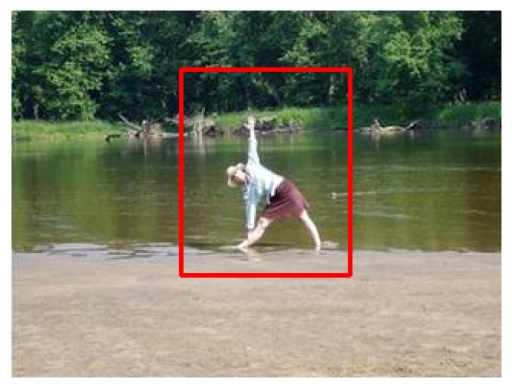

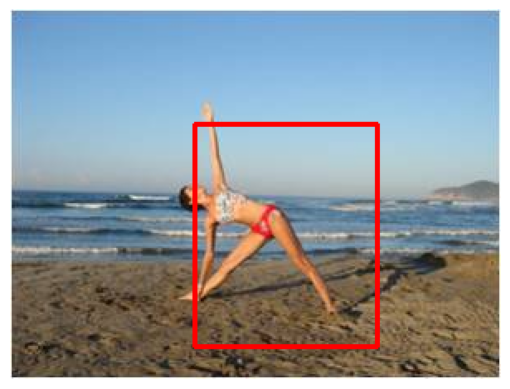

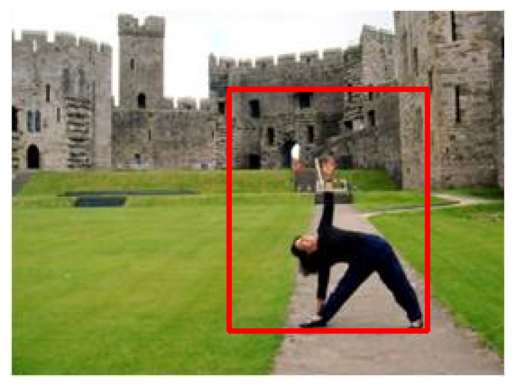

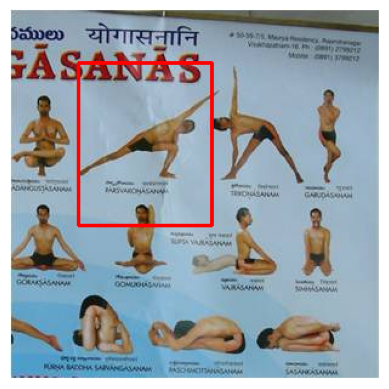

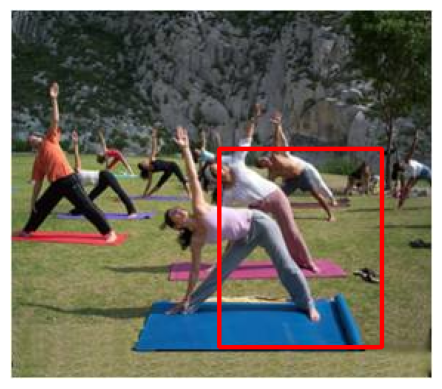

In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from skimage.color import rgb2lab
import time

def cal_ssd(patch, region, alpha, center_patch):
    patch_size = patch.shape
    region_size = region.shape
    SSD_region = np.zeros((region_size[0], region_size[1]))

    for row in range(center_patch[0], region_size[0] - center_patch[0]):
        for col in range(center_patch[1], region_size[1] - center_patch[1]):
            temp = region[row - center_patch[0]:row + center_patch[0] + 1, col - center_patch[1]:col + center_patch[1] + 1, :] - patch
            SSD_region[row, col] = np.sum(temp ** 2)
            SSD_region[row, col] = np.exp(-alpha * SSD_region[row, col])

    return SSD_region

def cart2polar(region_size):
    radius = np.zeros(region_size)
    angle = np.zeros(region_size)
    center = (region_size[0] // 2, region_size[1] // 2)

    for row in range(region_size[0]):
        for col in range(region_size[1]):
            rho, theta = np.hypot(row - center[0], col - center[1]), np.arctan2(row - center[0], col - center[1])
            radius[row, col] = np.log(rho) if rho != 0 else 0
            angle[row, col] = np.degrees(theta) + 180

    return radius, angle

def get_bin(radius, angle, region_size):
    max_radius = np.max(radius)
    bin = [[[] for _ in range(3)] for _ in range(15)]

    for m in range(15):
        theta_low, theta_up = m * 24, (m + 1) * 24
        for n in range(3):
            rho_low, rho_up = max_radius * n / 3, max_radius * (n + 1) / 3
            for row in range(region_size[0]):
                for col in range(region_size[1]):
                    if rho_low <= radius[row, col] <= rho_up and theta_low <= angle[row, col] <= theta_up:
                        bin[m][n].append((row, col))

    return bin

def get_self_sim_vec(ssd_region, bin, vec_size):
    self_similarities_vec = np.zeros(vec_size)
    num = 0

    for m in range(15):
        for n in range(3):
            max_value = 0
            for row, col in bin[m][n]:
                max_value = max(max_value, ssd_region[row, col])
            self_similarities_vec[num] = max_value
            num += 1

    return self_similarities_vec

def com_self_similarities(src_image, region_size, patch_size, bin):
    start_time = time.time()
    lab_image = rgb2lab(src_image)
    lab_size = lab_image.shape
    vec_size = 45
    alpha = 1 / (85 ** 2)
    self_similarities = np.zeros((lab_size[0], lab_size[1], vec_size))
    center_region = [region_size[0] // 2, region_size[1] // 2]
    center_patch = [patch_size[0] // 2, patch_size[1] // 2]

    for row in range(center_region[0], lab_size[0] - center_region[0]):
        for col in range(center_region[1], lab_size[1] - center_region[1]):
            patch = lab_image[row - center_patch[0]:row + center_patch[0] + 1, col - center_patch[1]:col + center_patch[1] + 1, :]
            region = lab_image[row - center_region[0]:row + center_region[0] + 1, col - center_region[1]:col + center_region[1] + 1, :]
            ssd_region = cal_ssd(patch, region, alpha, center_patch)
            vec = get_self_sim_vec(ssd_region, bin, vec_size)
            normalized_vec = (vec - np.min(vec)) / (np.max(vec) - np.min(vec))
            self_similarities[row, col, :] = normalized_vec

    print("Time taken:", time.time() - start_time)
    return self_similarities

def draw_result(src_img, sig_score_img, region_size, scale):
    x, y = np.unravel_index(np.argmax(sig_score_img), sig_score_img.shape)
    top_left = (int((y - region_size[1] // 2) * scale), int((x - region_size[0] // 2) * scale))
    bottom_right = (int((y + region_size[1] // 2) * scale), int((x + region_size[0] // 2) * scale))
    src_img_resized = cv2.resize(src_img, None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
    cv2.rectangle(src_img_resized, top_left, bottom_right, (0, 0, 255), 2)  

    # 显示带有红色边界框的原图
    plt.imshow(cv2.cvtColor(src_img_resized, cv2.COLOR_BGR2RGB))  
    plt.axis('off')
    plt.show()


n_img = 5  #加速
region_size = (135, 110)
patch_size = (5, 5)
radius, angle = cart2polar(region_size)
bin = get_bin(radius, angle, region_size)

width = 1
height = 1
center_sub = [width // 2, height // 2]

for m in range(1, n_img + 1):
    src_img = cv2.imread(f'Input/{m}.jpg')
    imgRgb = cv2.resize(src_img, (0, 0), fx=1, fy=1)
    p = 1  
    self_similarities1 = np.load(f'self_similarities0{m}.npy')
    img_size1 = self_similarities1.shape
    sig_score_img = np.zeros(img_size1[:2])
    step_size = 5 #加速

    for row1 in range(center_sub[0] + 1, img_size1[0] - center_sub[0], step_size):
        for col1 in range(center_sub[1] + 1, img_size1[1] - center_sub[1], step_size):
            sub1 = self_similarities1[row1 - center_sub[0]:row1 + center_sub[0]+1,
                                       col1 - center_sub[1]:col1 + center_sub[1]+1, :]
            max_match = np.zeros(n_img)
            match_score = []

            for n in range(1, n_img + 1):
                if m != n:  
                    self_similarities2 = np.load(f'self_similarities0{n}.npy')

                    sampled_self_similarities2 = self_similarities2[::step_size, ::step_size, :]
                    rows2, cols2, _ = sampled_self_similarities2.shape

                    temp1 = np.tile(sub1, (rows2, cols2, 1))
                    temp2 = -np.sum((sampled_self_similarities2 - temp1) ** 2, axis=2)
                    max_match[n - 1] = np.max(temp2)
                    match_score.append(temp2.flatten())

            if match_score:  
                temp3 = np.concatenate(match_score)
                avgMatch = np.mean(temp3)
                stdMatch = np.std(temp3)
                sig_score_img[row1, col1] = np.sum((max_match - avgMatch) / stdMatch)

    save_path = f'sig_img11{m}.npy'
    np.save(save_path, sig_score_img)

    # 画结果
    draw_result(src_img, sig_score_img / 4, region_size, 1)